In [13]:
import os
import json
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from openai import OpenAI

client = OpenAI(
    base_url="https://api.chatanywhere.tech/v1"
)

def chat(says):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": says,
            }
        ],
        model="gpt-4o-2024-05-13",
    )
    print("bots: "+chat_completion.choices[0].message.content)
    return  chat_completion.choices[0].message.content

def obj(x,y):
    return (x-2)**2+(y-3)**2


def Getvalue(ch,str):
    s = str.find(ch)
    e = str[s+1:].find(ch)
    return str[s+1:s+e+1]

def warm_strat(num):
    flag  = 1 #Determine whether the output meets the format.
    while flag:
        pt = (
            "You need to assume {} initial points for an optimization problem, and the objective function corresponding to the initial points should be as small as possible."
            "The objective function of this task is a binary quadratic function."
            "x1 must be within the range of [-5, 5]. x2 must be within the range of [-5, 5]."
            "According to the experience of previous tasks, the minimum value of the objective function may be around x1, x2 = 3, 3."
            "Please do not provide duplicate values."
            "Please give your answer and format your output as follows: *[],[],[],...,[]*").format(num)
        datas = Getvalue("*",chat(pt))
        datas = "[" + datas + "]"
        try:
            datas =  ast.literal_eval(datas)
        except Exception as e:
            continue
        if len(datas) == num:
            flag = 0
    return datas

def candidate_sampling(history,num):
    flag  = 1 #Determine whether the output meets the format.
    while flag:
        pt = (
            "Based on the previous optimization results {}, you need to provide {} candidate points for the next optimization."
            "The objective function of this task is a binary quadratic function."
            "x1 must be within the range of [-5, 5]. x2 must be within the range of [-5, 5]."
            "Please do not provide duplicate values."
            "Please give your answer and format your output as follows: *[],[],[],...,[]*").format(json.dumps(history),num)
        datas = Getvalue("*",chat(pt))
        datas = "[" + datas + "]"
        try:
            datas =  ast.literal_eval(datas)
        except Exception as e:
            continue
        if len(datas) == num:
            flag = 0
    return datas

agent_prompts = {
    "optimistic": "You are an optimistic agent. Inclined to explore uncertainties.",
    "pessimistic": "You are a pessimistic agent. Inclined to avoid risks.",
    "Conservative": "You are a conservative agent. You weigh the pros and cons to make decisions.",
}
def AcquisitionFunction(history,pred):
    
    m = 2
    inipt = ("{}"
            "You need to reasonably select the most potential parameters from the predicted data table based on your own experience and historical data tables for the next optimization step."
            "We hope you can balance the relationship between exploration and exploitation to achieve the best results."
            "The following is a historical data table, with format [Hyperparameters] - [loss]:"
            "{}"
            "The following is a predicted data table, with format [Hyperparameters] - [predloss]:"
            "{}"
            "A brief summary of your reasons, as concise as possible."
            "Please provide 2 sets of parameter combinations that you consider optimal, in the format *[],[]*")
    res = {"optimistic":"","Conservative":"","pessimistic":""}
    datas = []
    for i in agent_prompts.keys():
        flag  = 1 #Determine whether the output meets the format.
        while flag:
            pt = inipt.format(agent_prompts[i],json.dumps(history),json.dumps(pred))
            res[i] = chat(pt)
            str = Getvalue("*",res[i])
            str = "[" + str + "]"
            try:
                data =  ast.literal_eval(str)
            except Exception as e:
                continue
            if len(data) == 2:
                datas.append(data)
                flag = 0
                
    pt = ("{}"
            "The parameter combination chosen by the three of you is: "
            "{}"
            "The reasons for the choices made by the other two are: "
            "{} and {}"
            "A brief summary of your reasons, as concise as possible."
            "Please select one best parameter combination from those chosen by everyone, in the format *[]*")
    keys = list(agent_prompts.keys())
    for i in range(m):
        for index, key in enumerate(agent_prompts.keys()):
            flag  = 1 #Determine whether the output meets the format.
            while flag:
                pt = pt.format(agent_prompts[key],datas,res[keys[(index+1)%3]],res[keys[(index+2)%3]])
                print(pt)
                res[i] = chat(pt)
                str = Getvalue("*",res[i])
                str = "[" + str + "]"
                try:
                    data =  ast.literal_eval(str)
                except Exception as e:
                    continue
                if len(data) == 1:
                    flag = 0
    return data[0]

#AcquisitionFunction([{"params": [0, 0], "loss": 13}], [{"params": [1, 1], "loss": 10},{"params": [2, 1], "loss": 8},{"params": [2, 2], "loss": 6},{"params": [2, 3], "loss": 0}])

def SurrogateModel(history,samples):
    data_pred = []
    for i in range(len(samples)):
        flag  = 1 #Determine whether the output meets the format.
        while flag:
            pt = ("You are helping tune hyperparameters to minimize loss(>0)."
                "The objective function of this task is a binary quadratic function."
                "You need to guess the target function value for a given x based on historical evaluation data."
                "Below is the historical evaluation data, formatted as [Hyperparameters] - [loss]:"
                "{}"
                "As short as possible, do not provide too much information."
                "Please guess the loss for params:{} and format your output as follows: *xx*").format(history,samples[i])
            loss = re.findall(r'-?\d+\.\d+|-?\d+', Getvalue("*",chat(pt)))
            if len(loss) == 1:
                flag = 0
                new_entry = {"params": samples[i], "loss": float(loss[0])}
                data_pred.append(new_entry)
    return data_pred

In [14]:
 ### config
numiters = 10        # number of iters for BO
numinipoint = 3      # number of ini points
numsamples = 5       # number of sampled points

### initial
inidatas = warm_strat(numinipoint)
datas = []
arrloss = [1e6]
for i in inidatas:
    loss = obj(i[0],i[1])
    new_entry = {"params": [i[0], i[1]], "loss": loss}
    arrloss[0] = min(arrloss[0],loss)
    datas.append(new_entry)

bots: Based on the given information and the need to avoid duplicate values, the initial points can be chosen around the region where previous experience suggests the minimum might be. Therefore, the initial points within the given ranges could be:

*[3, 3],[2.5, 3.5],[3.5, 2.5]*


In [15]:
### Optimization   
for i in tqdm(range(numiters)):
    samplers = candidate_sampling(datas,numsamples)
    data_pred = SurrogateModel(datas,samplers)
    next_point = min(data_pred, key=lambda x: x['loss'])
    loss = obj(next_point["params"][0],next_point["params"][1])
    arrloss.append(loss)
    new_entry = {"params": next_point["params"], "loss": loss} 
    datas.append(new_entry)

  0%|          | 0/10 [00:00<?, ?it/s]

bots: *[3, 3.5], [2, 4], [3, 2], [2.5, 2], [4, 3]*
bots: *1.25*
bots: *0*
bots: *1.0*
bots: *0.25*


 10%|█         | 1/10 [00:05<00:48,  5.40s/it]

bots: *4*
bots: Based on the previous optimization results, I will provide 5 candidate points for the next optimization. These points will be chosen to cover a diverse range of values within the given constraints.

Here are the candidate points:

*[3.2, 3.3],[2.8, 3.7],[1.5, 4],[3.5, 3],[2, 3]*

These points aim to explore different regions in the range while attempting to balance between exploration and exploitation.
bots: *1.1*
bots: *0.7*
bots: *2.5*
bots: *1.75*


 20%|██        | 2/10 [00:12<00:50,  6.32s/it]

bots: *0.75*
bots: Given the previous results and the objective to minimize the loss of the binary quadratic function, here are five candidate points for the next optimization:

*[2.5, 3], [3.2, 3.3], [2.7, 3.4], [3.1, 3.1], [2.9, 3.2]*
bots: *0.5*
bots: *0.82*
bots: *0.71*
bots: *1.13*


 30%|███       | 3/10 [00:19<00:47,  6.74s/it]

bots: *0.90*
bots: Based on the previous optimization results, it seems that the loss function decreases significantly around \([2.5, 3] \approx 0.25\) and \([2.5, 3.5] \approx 0.5\). Therefore, I'll suggest candidate points around this region to explore.

Here are 5 candidate points for the next optimization:

*[2.4, 3], [2.5, 2.9], [2.6, 3.2], [2.3, 3.1], [2.7, 2.8]*
bots: *0.46*
bots: *0.27*
bots: *0.28*
bots: *0.4*


 40%|████      | 4/10 [00:27<00:42,  7.14s/it]

bots: *0.50*
bots: *[-2.5, 3.2], [2.6, 3.4], [2.4, 3.6], [2.7, 3.3], [2.3, 3.5]*
bots: *10.21*
bots: Based on the historical evaluation data, the guess for the loss for params [2.6, 3.4] is:
*0.48*
bots: *0.76*
bots: *0.35*


 50%|█████     | 5/10 [00:35<00:37,  7.42s/it]

bots: *0.4*
bots: Based on the previous optimization results and aiming to explore areas that have shown relatively low loss while also covering some new regions within the specified ranges, here are five candidate points for the next optimization:

*[-1, 3], [3, 1.5], [2.5, 4.2], [2, 3.4], [3.3, 2.8]*
bots: *18*
bots: *2.5*
bots: *1.7*
bots: *0.73*


 60%|██████    | 6/10 [00:42<00:29,  7.28s/it]

bots: *2*
bots: Based on the previous optimization results, the candidate points for the next optimization should be chosen to explore other areas of the parameter space while considering the minimization of the loss. Considering both exploitation (near good points) and exploration (diversity in parameter space) is important. Here are the 5 candidate points:

*[2.3, 3.2], [2.6, 3.1], [2.0, 3.6], [2.2, 3.5], [2.9, 3.4]*
bots: *0.15*
bots: *0.34*
bots: *0.25*
bots: *0.42*


 70%|███████   | 7/10 [00:51<00:23,  7.81s/it]

bots: *0.25*
bots: Based on the previous optimization results and looking for patterns that yielded lower losses, the 5 candidate points for the next optimization attempts could be:

*[2.4, 3.0], [2.6, 2.8], [2.3, 3.0], [2.7, 2.9], [2.2, 3.1]*
bots: *0.18*
bots: *0.27*
bots: *0.1*
bots: *0.3*


 80%|████████  | 8/10 [00:58<00:15,  7.61s/it]

bots: *0.15*
bots: Based on the previous optimization results and the objective function being a binary quadratic function, here are 5 candidate points for the next optimization:

*[-2.0, 3.2], [-2.3, 3.0], [-2.5, 2.8], [-2.7, 3.5], [-2.2, 3.1]*
bots: *17.01*
bots: *7.29*
bots: *19*
bots: *20*


 90%|█████████ | 9/10 [01:05<00:07,  7.33s/it]

bots: *6.612*
bots: Based on the previous optimization results, the areas with lower losses seem to be within the positive ranges of \( x1 \) and \( x2 \) near the values 2.5 to 3.5 range. However, there might be a potential minimum point slightly away from these areas as well. 

Here are 5 candidate points for the next optimization:

- [2.4, 3.05]
- [2.6, 2.95]
- [2.35, 3.15]
- [3.2, 2.85]
- [2.85, 3.4]
bots: Based on the previous optimization results, I will generate 5 new candidate points for the next optimization while ensuring they fall within the specified ranges and avoiding duplicate values. Considering the information given, the results suggest that lower loss values are found around the region near (2.3, 3.0). Here are the new candidate points:

*[-1, 1], [2.4, 3.1], [2.2, 2.9], [2.35, 3.05], [2.1, 3.2]*
bots: *10*
bots: *0.105*
bots: *0.21*
bots: *0.10*


100%|██████████| 10/10 [01:15<00:00,  7.59s/it]

bots: *0.14*


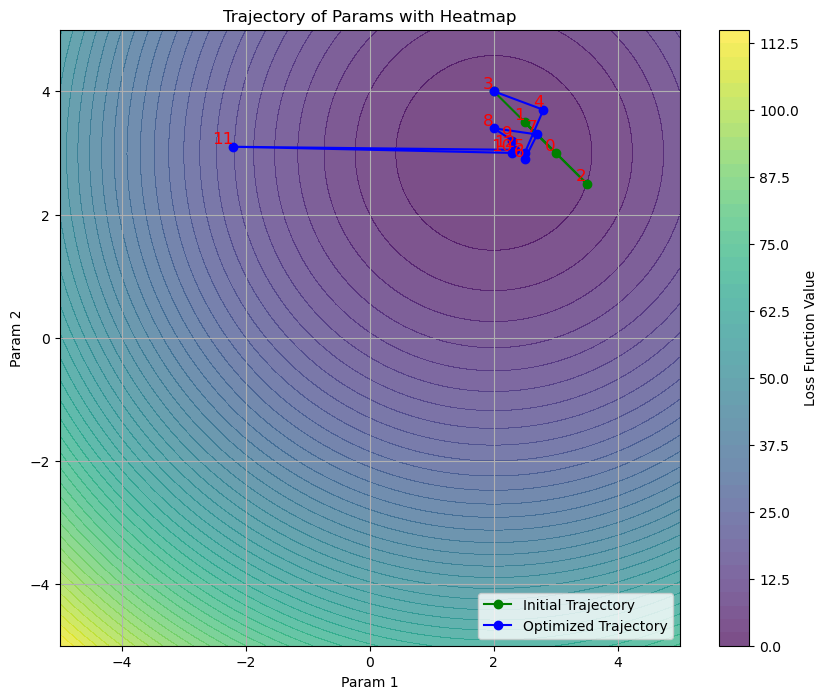

In [16]:
x_params = [item['params'][0] for item in datas]
y_params = [item['params'][1] for item in datas]
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

Z = (X - 2)**2 + (Y - 3)**2


plt.figure(figsize=(10, 8))

plt.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.7)
plt.plot(x_params[:numinipoint+1], y_params[:numinipoint+1], marker='o', linestyle='-', color='g', label='Initial Trajectory', zorder=4)
plt.plot(x_params[numinipoint:], y_params[numinipoint:], marker='o', linestyle='-', color='b', label='Optimized Trajectory', zorder=4)
for i, (x, y) in enumerate(zip(x_params, y_params)):
    plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom', color='red', zorder=5)
plt.colorbar(label='Loss Function Value')
plt.xlabel('Param 1')
plt.ylabel('Param 2')
plt.title('Trajectory of Params with Heatmap')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("trajectory1.pdf")
plt.show()

The final result is:  0.0899999999999999


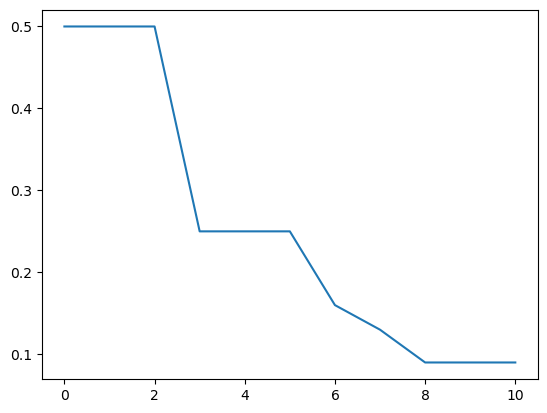

In [17]:
for i in range(len(arrloss)):
    arrloss[i] = min(arrloss[:i+1])
    
print("The final result is: ",min(arrloss))
plt.plot(arrloss)
plt.show()

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -1.0      | 3.0       | 3.0       |
| 2         | -0.5      | 2.5       | 3.5       |
| 3         | -2.5      | 3.5       | 2.5       |
| 4         | -53.54    | -3.912    | -1.311    |
| 5         | -13.0     | 5.0       | 5.0       |
| 6         | -73.0     | 5.0       | -5.0      |
| 7         | -53.0     | -5.0      | 5.0       |
| 8         | -3.035    | 0.947     | 1.612     |
| 9         | -7.219    | 0.2058    | 5.0       |
| 10        | -1.306    | 0.8608    | 3.091     |
| 11        | -0.6553   | 2.109     | 2.198     |
| 12        | -0.03394  | 1.816     | 2.994     |
| 13        | -4.013    | 2.115     | 5.0       |


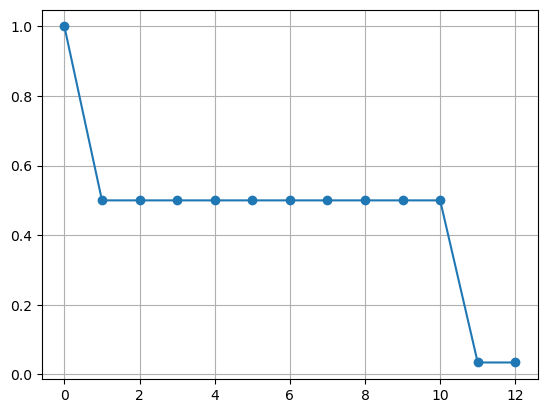

In [18]:
from bayes_opt import BayesianOptimization
pbounds = {'x': (-5, 5), 'y': (-5, 5)}
def target_function(x, y):
    return -(x-2)**2 - (y - 3)**2

optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    random_state=1,
)

initial_points = []
for i in range(3):
    new_entry = {'x': inidatas[i][0], 'y': inidatas[i][1]}
    initial_points.append(new_entry) 

for point in initial_points:
    optimizer.probe(
        params=point,
        lazy=True
    )

# 执行优化
optimizer.maximize(
    init_points=0,
    n_iter=10,
)

target_values = [-res['target'] for res in optimizer.res]
for i in range(len(target_values)):
    target_values[i] = min(target_values[:i+1])
plt.plot(target_values, marker='o')
plt.grid(True)
plt.show()

In [1]:
import LLMasOptimizer

datas = []
arrloss = [1e6]
for i in inidatas:
    loss = obj(i[0],i[1])
    new_entry = {"params": [i[0], i[1]], "loss": loss}
    arrloss[0] = min(arrloss[0],loss)
    datas.append(new_entry)
    
for i in range(10):
    point = LLMasOptimizer.Optimizer(datas)[0]
    datas.append({"params": point, "loss": obj(point[0],point[1])})
    arrloss.append(obj(point[0],point[1]))

for i in range(len(arrloss)):
    arrloss[i] = min(arrloss[:i+1])

plt.plot(arrloss, marker='o')
plt.grid(True)
plt.show()

NameError: name 'inidatas' is not defined